In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import cv2

try:
    from PIL import Image
except ImportError:
    import Image

In [3]:
IMAGES_DIR_PATH="./random-cars-dataset/images"
LABELS_DIR_PATH="./random-cars-dataset/license-numbers"

In [136]:
import os
images=[f for f in os.listdir(IMAGES_DIR_PATH)]

index: 8
image: ./random-cars-dataset/images/Cars107.png
width: 471, height: 270


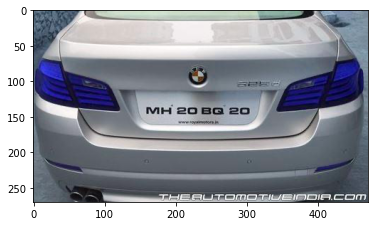

In [1675]:
from random import randint

#randomly selecting an image
# index=randint(0,len(images)-1)
# img_path=f'{IMAGES_DIR_PATH}/{images[index]}'

f_name='Cars107'
img_path=f'{IMAGES_DIR_PATH}/{f_name}.png'

#getting image size
im = Image.open(img_path)
width,height= im.size

print(f"index: {index}")
print(f"image: {img_path}")
print(f"width: {width}, height: {height}")

#displaying image
import cv2
img=cv2.imread(img_path)
plt.imshow(img)

## Detection

In [1596]:
%cd yolov5
!python detect.py --weights ./runs/train/exp/weights/best.pt --source ../{img_path} --save-txt --exist-ok
%cd ..

C:\Users\HP\Desktop\ML\ANPR\yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=True, img_size=640, iou_thres=0.45, name='exp', nosave=False, project='runs/detect', save_conf=False, save_txt=True, source='.././random-cars-dataset/images/Cars65.png', update=False, view_img=False, weights=['./runs/train/exp/weights/best.pt'])
Fusing layers... 
image 1/1 C:\Users\HP\Desktop\ML\ANPR\yolov5\..\random-cars-dataset\images\Cars65.png: 544x640 1 license_plate, Done. (0.306s)
Results saved to runs\detect\exp
85 labels saved to runs\detect\exp\labels
Done. (0.334s)
C:\Users\HP\Desktop\ML\ANPR


YOLOv5  5352f33 torch 1.8.1+cpu CPU

Model Summary: 224 layers, 7053910 parameters, 0 gradients, 16.3 GFLOPS


133 105 331 177


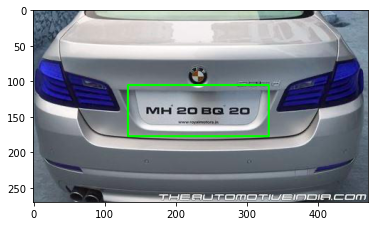

In [1676]:
#opening predicting bounding box file
# f_name=images[index].split('.')[0]
label_file=open(f'./yolov5/runs/detect/exp/labels/{f_name}.txt')

#reading line
s=label_file.readline().replace('\n','').split(' ')

#******extracting bounding box********#
s=[ float(i) for i in s]    #[conf center_x center_y width height] 

bottom_x=((2*s[1]+s[3])/2)
top_x=bottom_x-s[3]

bottom_y=((2*s[2]+s[4])/2)
top_y=bottom_y-s[4]

top_x=int(top_x*width)
bottom_x=int(bottom_x*width)

top_y=int(top_y*height)
bottom_y=int(bottom_y*height)
#*************************************#

print(f'{top_x} {top_y} {bottom_x} {bottom_y}')

import copy
img1=copy.copy(img)

img1=cv2.rectangle(img1,(top_x,top_y),(bottom_x,bottom_y),(0,255,0),2)
plt.imshow(img1)


## Image pre-processing

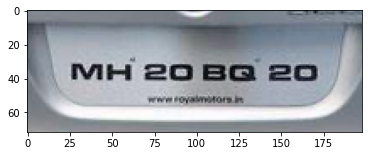

In [1677]:
#cropping the license plate from the original image
plate=img[top_y:bottom_y,top_x:bottom_x]
plt.imshow(plate)

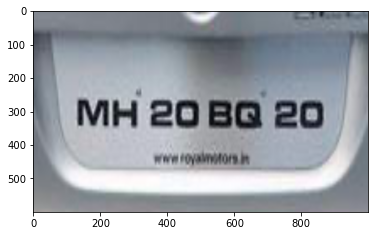

In [1678]:
# resize image to three times as large as original for better readability
plate=cv2.resize(plate,(1000,600),interpolation=cv2.INTER_LINEAR)
plt.imshow(plate,cmap="gray")

#storing plate copy for displaying segmentation
import copy
plate_copy=copy.copy(plate)

In [1679]:
# def inc_contrast(img):
#     #-----Converting image to LAB Color model----------------------------------- 
#     lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

#     #-----Splitting the LAB image to different channels-------------------------
#     l, a, b = cv2.split(lab)

#     #-----Applying CLAHE to L-channel-------------------------------------------
#     clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
#     cl = clahe.apply(l)


#     #-----Merge the CLAHE enhanced L-channel with the a and b channel-----------
#     limg = cv2.merge((cl,a,b))

#     #-----Converting image from LAB Color model to RGB model--------------------
#     final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
#     return final
#     #_____END_____#

# plate=inc_contrast(plate)
# plt.imshow(plate,cmap="gray")

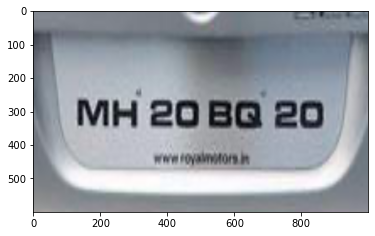

In [1680]:
#plate=cv2.GaussianBlur(plate, (5,5), 0)
plate=cv2.bilateralFilter(plate,9,2,100)
plt.imshow(plate,cmap="gray")

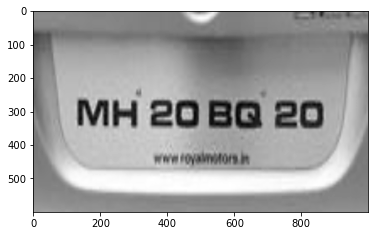

In [1681]:
#converting to gray scale
plate=cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
plt.imshow(plate,cmap="gray")

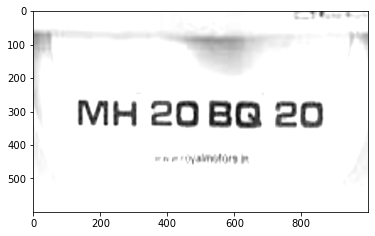

In [1682]:
plate=cv2.multiply(plate,2)
plt.imshow(plate, cmap="gray")

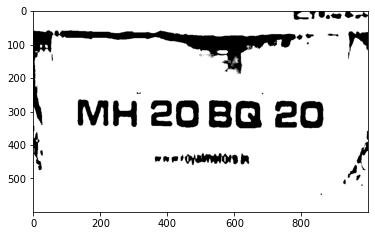

In [1683]:
# plate=cv2.threshold(plate, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)[1]
plate=cv2.adaptiveThreshold(plate,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,199,5)
plt.imshow(plate, cmap="gray")

## Character Segmentation

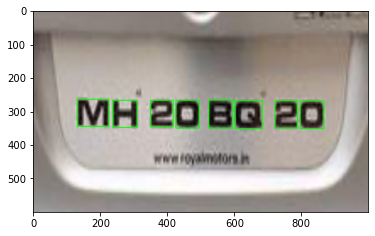

No of characters: 8


In [1689]:
contours,_=cv2.findContours(plate, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])
chars=[]
widths=[]
heights=[]

segmented_plate=plate_copy.copy()

for cont in contours:
    x,y,w,h=cv2.boundingRect(cont)
    
    #w: width of character
    #h height of character
    
    #shape of plate
    height_of_plate,width_of_plate=plate.shape
    
    #.......removing noise........#
    
    #if char is too wide then skip
    if width_of_plate<2*w: continue        
        
    #if char is too short in height then skip
    if height_of_plate>8*h: continue
        
    #if char h/w ratio is less than 1 or more than 10
    ratio=h/float(w)
    if ratio<0.5 or ratio>10: continue
        
    #if area is less than 100 pixels
    if h*w<70: continue
        
    #.............................#
    
    #checking if contour inside already added contour
    f=0
    for c in chars:
        x1,y1,w1,h1=cv2.boundingRect(c)
        if x>x1 and x+w<x1+w1 and y>y1 and y+h<y1+h1:
            #contour not useful, mark flag to 1
            f=1
            break
    
    if f==1: continue
    #...............................................#
    
    
    #check if its in corner
    if x==0 or y==0 or x+w==width_of_plate or y+h==height_of_plate:
        continue    
    #.....................
    
    #appending valid contour
    chars.append(cont)
    widths.append(w)
    heights.append(h)
    
#comparing height and width of charactes with median height and width
from statistics import median
mw=median(widths)
mh=median(heights)

def is_hw_ok(cont):
    x,y,w,h=cv2.boundingRect(cont)
    
    if h/mh<0.55 or h/mh>2 or w/mw<0.33 or w/mw>3: return False
    
    return True

chars=[char for char in chars if is_hw_ok(char)]
    
#......................................................................
    

#drawing all the segments on the image
for char in chars:
    x,y,w,h=cv2.boundingRect(char)
    #drawing segment for the character on the plate
    segmented_plate=cv2.rectangle(segmented_plate,(x,y),(x+w,y+h),(0,255,0),2)

#displaying segmented plate
segmented_plate=cv2.cvtColor(segmented_plate,cv2.COLOR_BGR2RGB)
plt.imshow(segmented_plate)
plt.show()

#number of characters segmented
print(f"No of characters: {len(chars)}")

## Character Recognition

In [1686]:
#utility function to convert number(0-35) to label(0-9, A-Z)
def to_label(n):
    if n<=9:
        return str(n)
    
    return chr(n-10+ord('A'))

License plate: MH2QBG2Q


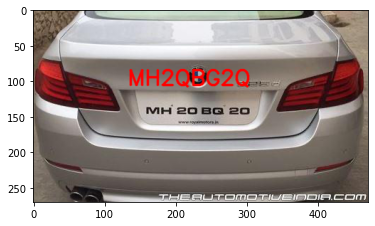

In [1687]:
from itertools import chain
# from google.colab.patches import cv2_imshow


#loading recognition model
from keras.models import load_model
char_recognizer=load_model('char_recog_lenet_model.h5')

label=""
index=0

#iterating over contours
for char in chars:
    x,y,w,h=cv2.boundingRect(char) #w: width of character, h: height of character
    
    roi=plate[y:y+h,x:x+w]
    
    point=plate[char[0][0][1]+1][char[0][0][0]]
    
    #if char is white
    if point==255:
        roi=cv2.bitwise_not(roi)
        
    #adding padding
    roi=cv2.copyMakeBorder(roi,8,8,8,8,cv2.BORDER_CONSTANT,value=[255,255,255])
    
    #resizing image to model input format (28x28)
    roi=cv2.resize(roi,(28,28))
    
    
    #erode
#     kernel=np.ones((2,2),np.uint8)
#     roi=cv2.erode(roi,kernel,iterations = 1)
#     roi=cv2.dilate(roi,kernel,iterations = 2)

    
    #converting roi into required format
    roi=roi.reshape(28,28,1)
    
    cv2.imwrite(f'./output/{index}.jpg',roi)
    
    #predicting label using model
    pred=char_recognizer.predict(np.array([roi]))
    
    #finding label mith max probability
    pred=np.argmax(pred)
    
    label+=to_label(pred)
    
    index+=1

import copy
final_img=copy.copy(img)
final_img=cv2.putText(final_img,label,(top_x,top_y),cv2.FONT_HERSHEY_SIMPLEX,1,(0, 0, 255),2,cv2.LINE_AA)
final_img=cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)
plt.imshow(final_img)
print(f"License plate: {label}")